# The Effect of a Tumor in the Brain's Temperature

by Geraldo Marques de Sousa Junior and Yuichi Tokumoto

March $25^{th}$, 2021

In [1]:
from mshr import Polygon, generate_mesh
import numpy as np
import mshr
from matplotlib import pyplot as plt
from dolfin import *
from fenics import *

## 1. Introduction

The main aim of the present work is to determine the effect of a cancereous tissue in the temperature distribution of its region in the brain. The temperature distribution in the tumor and healthy tissues was obtained based on the solution of Penne's bio-heat transfer equation utilizing the Finite Element scheme.

## 2. Presentation of the Problem

### 2.1. Introduction of the steady state Bio-Heat Equation

This equation is a typical example of a parabolic Partial Differential Equation. However, in this particular project, we will be interested in the steady state solution, i.e. when $t\to\infty$ and $\lim_{t\to\infty} \partial_t\theta = 0 $ where $\theta$ is our unkown function, that represents the temperature $[°C]$.

Therefore, we can get the following equation (from [[1]]), which will be used in this project:

\begin{equation}\label{eq1:eval}
 \tag{P}\begin{cases}
  -\nabla(\kappa\nabla(\theta) - \rho_{b} c_{b} \omega_{b} (\theta_{b} - \theta) = Q_{met} \mbox{ in  }\Omega,\\
  -\kappa \nabla\theta = h_{a}(\theta - \theta_{e}) \mbox { in } \partial\Omega
 \end{cases}
\end{equation}

Where $\kappa$ $[W/m\,°C]$ is the thermal conductivity, $\rho_{b}$ $[kg/m^3]$ is the density of blood, $c_{b}$ $[J/kg °C]$ is the specific heat of blood, $\omega_{b}$ $[s^{-1}]$ is the blood perfusion rate, $\theta_{b}$ $[°C]$ is the temperature of blood, $\theta_{e}$ $[°C]$ is the temperature of the brain, $h_{a}$ $[J/(m\, s \, °C)]$is the heat transfer coefficient and $Q_{met}$ $[W/m^3]$ is the metabolic heat generation.

[1]:https://link.springer.com/content/pdf/10.1007/s42452-021-04447-1.pdf

### 2.2. Definition of the Constants

We can then determine ([[1]], [[2]]) the values of our constants.

Let $\omega_{b}$ be the blood perfusion rate in the cancerous tissue and $\omega_{b_{ normal}}$ be the blood perfusion rate in a healthy tissue.

Let $\kappa$ be the thermal conductivity in the cancerous tissue and $\kappa_{normal}$ be in a healthy tissue.

\begin{equation}
 \begin{cases}
  \rho_{b} = 1052 \, kg/m^3 \\
   c_{b} = 3800 \, J/kg °C \\
  \omega_{b} = 0.0016 \, s^{-1} \\
  \omega_{b_{ normal}} = 0.003695 \, s^{-1} \\
  h_{a} = 8 \, W/(m\, °C) \\
  \kappa = 0.565 \, W/(m\, ºC) \\
  \kappa_{normal} = 0.503 \, W/(m\, ºC)
 \end{cases}
\end{equation}

[1]:https://link.springer.com/content/pdf/10.1007/s42452-021-04447-1.pdf
[2]:http://mj-med-u-tokai.com/pdf/440403.pdf

### 2.3. Definition of the Random Variable

In this problem, we are going to set the temperature of the blood following a normal distribution based on ([[4]]), and the temperature of the brain following a uniform distribution (based on ([[3]]), such that:

- $\theta_{b} = \mathcal{N}(36.5, 0.5) \, °C$

- $\theta_{e} = \mathcal{U}(36.5, 37.3) \, °C$

[3]:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4189373/
[4]:http://www.diva-portal.org/smash/get/diva2:37698/FULLTEXT01.pdf

Thus, we can define those values in our code:

In [2]:
ro_b = 1052 #kg/m3
c_b = 3800 #J/kg*ºC
w_b = 0.0016 #ml/(ml.s)
k = 0.565 #W/(m*ºC)
h = 8 #W/(m*K)

w_b_normal = 0.003695 #ml/(ml.s)
k_normal = 0.503 #W/(m*ºC)
h = 8 #W/(m*K)

T_b = np.random.normal(loc = 36, scale = 0.5)
T_e = np.random.uniform(low=36.9-.4, high=36.9+.4)

print(T_b)

35.865594319278706


### 2.4. Definition of the domain

Either in a healthy tissue, either in the tumorous region, we will describe the domain as a circle of radius $0.015m$, as suggested in ([[1]]).

[1]:https://link.springer.com/content/pdf/10.1007/s42452-021-04447-1.pdf

### 2.5. Definition of $f$ (source term)

$f: (x,y) \mapsto Q_{met} \; (1 - x^2/0.000225-y^2/0.000225 )$ ,

which represents the dispersion of the metabolic generation on the tumor, which is maximum at the core and then decreases continuously.

$f_{normal}: (x,y) \mapsto Q_{met_{normal}} \; (1 - x^2/0.000225-y^2/0.000225)$ ,
which represents the dispersion of the metabolic generation on the healthy tissue, which is maximum at the core and then decreases continuously.

Let us then define $f$ and $f_{normal}$ in our Python script, using the Expression tool from FeniCS.
 

In [3]:
Q_met_normal = 4517.9 #W/m^3
Q_met = 25000 #W/m^3

f = Expression(str(Q_met)+'*(1 -(x[0]*x[0]/0.000225+x[1]*x[1]/0.000225))', degree = 2) 
f_normal = Expression(str(Q_met_normal)+'*(1 -(x[0]*x[0]/0.000225+x[1]*x[1]/0.000225))', degree = 2) 

## 3. Solution of the problem

### 3.1. Meshing the domain

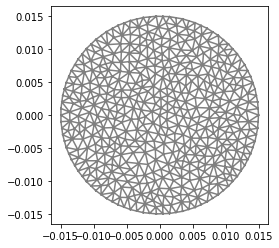

In [4]:
domain = mshr.Circle(Point(0, 0), .015)
mesh = mshr.generate_mesh(domain, 15)
plot(mesh)

### 3.2. Defining the approximation Space


We need to define the space on which we will look for our approximate solution. Since it doesn't vanish on the boundary, we will choose $\mathcal{H}_h$ = {$v \in \mathcal{H}^1 : v_{|\partial\Omega} \in \mathcal{P}^1$}. 

Thus, we define $\mathcal{H}_h$ in our Python script. 

In [5]:
Hh = FunctionSpace(mesh, 'P', 1)

### 3.3. Variational Approximation

For the weak formulation (WF), let's consider a function $\phi$ $\in$ $\mathcal{D}(\overline{\Omega})$. Then, we write:

\begin{equation}
 \int_\Omega -\nabla(\kappa \nabla(u)) \phi - \rho_{b} c_{b} \omega_{b} (\theta_{b} - u) \phi = \int_\Omega f \phi. 
\end{equation}

Using Integration by Parts on the left hand side and applying the Robin's boundary condition, we get:


\begin{equation}
 \tag{WF}
  \int_\Omega \kappa \nabla(u) \nabla(\phi) + \int_{\partial\Omega}  (h (u - \theta_{e}) \phi - \int_\Omega \rho_{b} c_{b} \omega_{b} (\theta_{b} - u) \phi = \int_\Omega f \phi ,   \forall \phi \in \mathcal{D}(\overline{\Omega})
\end{equation}

For the Variational Formulation (VF), let's Consider a Space $\mathcal{H}$ = $\mathcal{H}^1(\Omega)$. Then, we can define the bilinear form $a(u,v)$ and the linear form $l(v)$.

$a: \mathcal{H} x \mathcal{H} \rightarrow \mathbb{R}$

$ \quad \; (u,v) \mapsto \int_\Omega \kappa \nabla(u) \nabla(\phi) + \int_{\partial\Omega}  h \,u\, v + \int_\Omega \rho_{b} c_{b} \omega_{b} \,u\, v$

$l: \mathcal{H} \rightarrow \mathbb{R}$

$ \quad \:  v \mapsto \int_\Omega f v + \int_\Omega \rho_{b} c_{b} \omega_{b} \theta_{b} v + \int_{\partial\Omega}  h \theta_{e}  v$


We now add the variational formulation as defined above to the Python script.

In [6]:
u = TrialFunction(Hh)
v = TestFunction(Hh)

a = k*dot(grad(u), grad(v))*dx + ro_b*c_b*w_b*u*v*dx + h*u*v*ds
l = f*v*dx + ro_b*c_b*w_b*T_b*v*dx + h*T_b*v*ds

a_normal = k_normal*dot(grad(u), grad(v))*dx + ro_b*c_b*w_b_normal*u*v*dx + h*u*v*ds
l_normal = f_normal*v*dx + ro_b*c_b*w_b_normal*T_b*v*dx + h*T_e*v*ds


### 3.4. Solving and plotting the solution 

Then, we can just solve, for both the healthy and cancerous tissues, the problem: Find $u_h \in \mathcal{H}_h$ s.t  $\, \forall v_h \in \mathcal{H}_h \: ,a(u_h,v_h) = l(v_h)$ and plot the obtained solutions.

#### 3.4.1. Plotting the temperature distribution in the cancerous region

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'Temp.[°C] in the tumour')

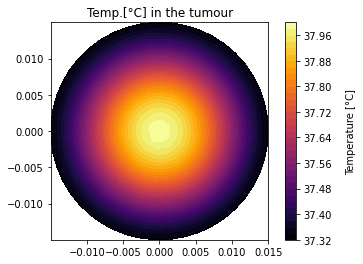

In [7]:
u = Function(Hh)
solve(a == l, u)
u_normal = Function(Hh)
solve(a_normal == l_normal, u_normal)

a = plot(u, cmap='inferno')
cb_a = plt.colorbar(a)
cb_a.set_label("Temperature [°C]", labelpad= 15)
plt.title('Temp.[°C] in the tumour')

#### 3.4.2. Plotting the expected temperature distribution in the healthy region

Text(0.5, 1.0, 'Expected temp.[ºC] in the healthy tissue')

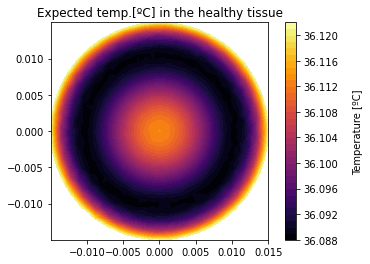

In [8]:
c = plot(u_normal, cmap='inferno')
cb_c = plt.colorbar(c)
cb_c.set_label("Temperature [ºC]", labelpad=15)
plt.title("Expected temp.[ºC] in the healthy tissue")

#### 3.4.3. Plotting the difference of temperature of the tumorous region and the expected distribution in a healthy tissue

Text(0.5, 1.0, 'Diff. between tumour and normal condition')

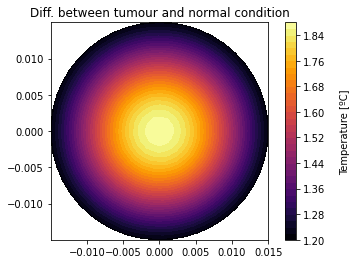

In [9]:
b = plot(u - u_normal, cmap='inferno')
cb_b = plt.colorbar(b)
cb_b.set_label("Temperature [ºC]", labelpad=15)
plt.title("Diff. between tumour and normal condition")

## 4. Analysis of the solution and conclusions


### 4.1. Temperature distribution on the tumour

Even if we used a really simple model, if compared to the complexity of the human body, we were able to get some great and insightful results regarding the temperature distribution in the human body. If we compare the first plot we got with a result from [[1]], represented in figure 3.b, we can notice that the temperature distribution on the tumour is actually quite accurate for the case-study. We notice that the temperature in the centre of the tumour (for this simulation we consider a tumour of radius 0.015m) is around 2ºC (plot 3 - section 3.4.3.) greater than the expected value for healthy tissue, accordingly to the proposed reference [[1]]. 

### 4.2. Analysis of consequences of temperature increase

As proposed in [[5]], temperature changes greater than 1ºC in the brain can result in functional alterations in various areas of the nervous system, reinforcing the high thermal sensitivity of the brain. Thus, analysing our simulations and the ones provided in [[1]], shows that the rise in temperature on the affected region is directly responsible for pain and for neural function arrest, highlighting the dangerousness of this type of tumour.

### 4.3. Effect of randomness on the model

We developed our model using random variables to describe the brain temperature ($\theta_{e}$) and the blood temperature ($\theta_{b}$), making it possible to analyse multiple scenarios described in the literature with the defined temperature distributions. 
If we simulate multiple times we can see that indeed, both results change, mainly in relation to the range of the temperatures. This is obviously expected, since we are changing some characteristics of the blood and brain temperatures. However, we can notice that the patterns are maintained, i.e. we always get results such as described in the items above. That happens because we selected random values from intervals that are in accordance with the model's assumptions.

### 4.4. Final thoughts

In general, the model could describe the expected results associated with the temperature distribution of an affected zone and how it can stop the equilibrium of the brain, causing pain and neural function arrest. Some ideas for future project are to propose a 3D model, as done in section 3.3 of [[1]] and simulate the proposed treatment [[1]] of hyperthermia. 
Overall, the project provided some useful insights and allowed the group to develop some key modelling skills.



[1]:https://link.springer.com/content/pdf/10.1007/s42452-021-04447-1.pdf
[5]:https://www.frontiersin.org/articles/10.3389/fnins.2014.00307/full

## 5. References

[1]: *Numerical study on the effects of blood perfusion and tumor metabolism on tumor temperature for targeted hyperthermia considering a realistic geometrical model of head layers using the finite element method*, available at: https://link.springer.com/content/pdf/10.1007/s42452-021-04447-1.pdf

[2]: *Measurements of Specific Heat Capacities Required to Build Computer Simulation Models for Laser Thermotherapy of Brain Lesions*, available at: http://mj-med-u-tokai.com/pdf/440403.pdf

[3]: *Brain temperature and its fundamental properties: a review for clinical neuroscientists*, available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4189373/

[4]: *Simulation and Calculation of Magnetic and Thermal Fields of Human using Numerical Method and Robust Soft wares*, available at: http://www.diva-portal.org/smash/get/diva2:37698/FULLTEXT01.pdf